# 2024 CITS4012 Project

# ReadMme

# 1. Dataset Processing

## Importing Libraries

In [4]:
import re
import json
import nltk
import time
import math
import spacy
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gensim.downloader as api
import matplotlib.pyplot as plt

## Loading Datasets

In [5]:
# Load the training data
# with open('/content/drive/MyDrive/data/train.json', 'r') as file:
with open('train.json', 'r') as file:
    data = json.load(file)
    train_data = pd.DataFrame(data['data'], columns=data['columns'])

# Load the test data
# with open('/content/drive/MyDrive/data/test.json', 'r') as file:
with open('test.json', 'r') as file:
    data = json.load(file)
    test_data = pd.DataFrame(data['data'], columns=data['columns'])

# Load the validation data
# with open('/content/drive/MyDrive/data/val.json', 'r') as file:
with open('val.json', 'r') as file:
    data = json.load(file)
    val_data = pd.DataFrame(data['data'], columns=data['columns'])

# Get the x and y lists for training data and test data
training_x = train_data['sentence'].tolist() + val_data['sentence'].tolist()
training_a = train_data['aspect'].tolist() + val_data['aspect'].tolist()
training_y = train_data['polarity'].tolist() + val_data['polarity'].tolist()
test_x = test_data['sentence'].tolist()
test_a = test_data['aspect'].tolist()
test_y = test_data['polarity'].tolist()

## Dataset Analysis

In [6]:
# Size of datasets
print("Training data size :", len(training_x))
print("Test data size     :", len(test_x))

# Aspect Distribution
aspect_distribution = train_data['aspect'].value_counts()
print("\nAspect Distribution:")
print(aspect_distribution.to_string(header=False))

# Sentiment Distribution
sentiment_distribution = train_data['polarity'].value_counts()
print("\nSentiment Distribution:")
print(sentiment_distribution.to_string(header=False))

# Aspect-Sentiment Pair Distribution
aspect_polarity_pair = [(a, p) for a, p in zip(train_data['aspect'], train_data['polarity'])]
aspect_polarity_freq = pd.Series(aspect_polarity_pair).value_counts()
print("\nAspect-Sentiment Pair Distribution:")
print(aspect_polarity_freq.to_string(header=False))

Training data size : 7978
Test data size     : 901

Aspect Distribution:
food             2307
staff            1383
miscellaneous     954
place             694
service           631
menu              475
ambience          324
price             322

Sentiment Distribution:
neutral     3077
negative    2084
positive    1929

Aspect-Sentiment Pair Distribution:
(food, neutral)              1298
(staff, negative)             922
(food, positive)              754
(miscellaneous, neutral)      531
(place, neutral)              430
(menu, neutral)               372
(staff, positive)             332
(service, negative)           329
(food, negative)              255
(miscellaneous, positive)     227
(miscellaneous, negative)     196
(ambience, positive)          181
(service, positive)           174
(place, negative)             139
(price, neutral)              136
(staff, neutral)              129
(service, neutral)            128
(place, positive)             125
(price, negative)         

## Data Preprocessing

In [7]:
! python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 393.8 kB/s eta 0:00:33
     --------------------------------------- 0.1/12.8 MB 901.1 kB/s eta 0:00:15
     - -------------------------------------- 0.4/12.8 MB 2.2 MB/s eta 0:00:06
     -- ------------------------------------- 0.7/12.8 MB 3.0 MB/s eta 0:00:05
     -- ------------------------------------- 0.9/12.8 MB 3.5 MB/s eta 0:00:04
     --- ------------------------------------ 1.2/12.8 MB 3.8 MB/s eta 0:00:04
     ---- ----------------------------------- 1.5/12.8 MB 4.2 MB/s eta 0:00:03
     ----- ---------------------------------- 1.7/12.8 MB 4.4 MB/s eta 0:00:03
     ------ --------------------------------- 2.0/12.8 MB 4.6 MB/s eta 0:00:03
     ------- -------------------------------- 2.3/12.8 MB 4.7 MB/s eta 0:00:03
     ------- -------------------------------- 2.5/12.8 MB 4.8 MB

In [8]:
# Punctuation Removal
def remove_punctuation_re(x):
    x = re.sub(r'[^\w\s]', '', x)
    return x

nltk.download('punkt')

# Stopwords Removal
nlp = spacy.load("en_core_web_sm")

def remove_stopwords(x):
    doc = nlp(x)
    x = [word.text for word in doc if not word.is_stop]
    return x

# Stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stem(x):
    x = [stemmer.stem(word) for word in x]
    return x

# Lemmatisation
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize(x):
    x = [lemmatizer.lemmatize(word) for word in x]
    return x

# English Contractions Dictionary
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

# Emoticons
EMOTICONS = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
      |
      <3                         # heart
    )"""

EMOTICON_RE = re.compile(EMOTICONS, re.VERBOSE | re.I | re.UNICODE)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\allis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\allis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
# Function to preprocess the data
def preprocess_data(sentence_list):
    output_list = []
    for sentence in sentence_list:
        emoticons = EMOTICON_RE.findall(sentence)       # Extract emoticons
        sentence = EMOTICON_RE.sub('', sentence)        # Remove emoticons
        sentence = sentence.lower()                     # Case folding
        for word, new_word in contraction_dict.items(): # Deal with contractions
            sentence = sentence.replace(word, new_word)
        sentence = remove_punctuation_re(sentence)      # Remove punctuation
        tokens = remove_stopwords(sentence)             # Remove stopwords / Tokenise
        # tokens = stem(tokens)                           # Stemming
        # tokens = lemmatize(tokens)                      # Lemmatisation
        tokens.extend(emoticons)                        # Add emoticons back
        output_list.append(tokens)
    return output_list

# Preprocess the data and get the tokenised sentence lists
train_x_token = preprocess_data(training_x)
test_x_token = preprocess_data(test_x)

## Create Word Vocabulary

In [10]:
# Get longest sentence length
longest_sentence = max(train_x_token, key=len)
MAX_LENGTH = len(longest_sentence)

# Word vocabulary to index dictionary {word: index}
word_to_idx = {'<PAD>': 0, '<SEP>': 1}
review = train_x_token + test_x_token
aspect = [list(set(training_a))]
polarity = [list(set(training_y))]

# Vocabulary includes words from reviews and aspects
for sentence in aspect+review:
    for word in sentence:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)
word_list = list(word_to_idx.keys())
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(word_to_idx)

# Polarity vocabulary to index dictionary {polarity: index}
polarity_to_idx = {p: i for i, p in enumerate(polarity[0])}
idx_to_polarity = {idx: pol for pol, idx in polarity_to_idx.items()}

## Convert Words to Index form

In [11]:
def list_to_index(token_list, word_to_idx):
    idx_list = []
    for tokens in token_list:
        idx_list.append([word_to_idx[token] for token in tokens])
    return idx_list

def string_to_index(aspect_list, word_to_idx):
    idx_list = []
    for aspect in aspect_list:
        idx_list.append(word_to_idx[aspect])
    return idx_list

# Append aspect to the end of the sentence
def combine_sentence_aspect(sentence, aspect):
    sep_idx = word_to_idx['<SEP>']
    combined_idx = sentence + [sep_idx] + [aspect]
    return combined_idx

# Token index lists for training data
train_x_idx = list_to_index(train_x_token, word_to_idx)
train_a_idx = string_to_index(training_a, word_to_idx)
train_y_idx = string_to_index(training_y, polarity_to_idx)
train_xa_idx = []
for x, a in zip(train_x_idx, train_a_idx):
    train_xa_idx.append(combine_sentence_aspect(x, a))

# Get the longest sentence length after appending aspect
longest_combined_sentence = max(train_xa_idx, key=len)
MAX_COMBINED_LENGTH = len(longest_combined_sentence)

## Pretrained Word Embeddings from Glove

In [ ]:
glove_model = api.load("glove-twitter-50")
glove_weights = torch.FloatTensor(glove_model.vectors)

# 2. Model Implementation

In [23]:
# Model
class Chaydeyn(nn.Module):
    def __init__(self, hidden_size, output_size, embedding, num_layers=1):
        super(Chaydeyn, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = embedding
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers)
        self.linear = nn.Linear(self.hidden_size*2, self.output_size)

    def forward(self, input, hidden, cell, encoder_hiddens, aspect, is_last):
        word_embedding = self.embedding(input).view(1, 1, -1)
        aspect_embedding = self.embedding(aspect).view(1, 1, -1)
        embedded = torch.cat((aspect_embedding, word_embedding), 0)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        if is_last:
            attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0))/np.sqrt(hidden.size(-1)),dim=-1)
            attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
            concat_output = torch.cat((attn_output[0], hidden[0]), 1)
            output = F.log_softmax(self.linear(concat_output), dim=1)
        return output, (hidden, cell)

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [24]:
# Function to get time elapse for training
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

# Function to feep input tensor into encoder
def feed_encoder(encoder, input_tensor, aspect_tensor, max_length):
    encoder_hiddens = torch.zeros(max_length, encoder.hidden_size) # For attention mechanism
    encoder_hidden = encoder.init_hidden() # Hidden state for encoder
    for i in range(input_tensor.size(0)):
        encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[i], encoder_hidden, aspect_tensor)
        encoder_hiddens[i] = encoder_hidden[0, 0]
    return encoder_hidden, encoder_hiddens

# Function to prepare data for training
def prepare_data(random_idx):
    # Input data
    x_index = [[idx] for idx in train_x_idx[random_idx]]
    x_tensor = torch.LongTensor(x_index)
    
    a_index = train_a_idx[random_idx]
    a_tensor = torch.LongTensor([a_index])
    
    x_temp = train_x_idx[random_idx]
    xa_combined = combine_sentence_aspect(x_temp, a_index)
    xa_index = [[idx] for idx in xa_combined]
    xa_tensor = torch.LongTensor(xa_index)
    
    # Target data
    y_index = train_y_idx[random_idx]
    y_tensor = torch.LongTensor([y_index])
    
    return x_tensor, a_tensor, xa_tensor, y_tensor

In [28]:
# Function to train model
def train(embedding, attention_type, integration_type,
          num_epochs=10000, 
          print_interval=500, 
          plot_interval=200, 
          learning_rate=0.001, 
          hidden_size=64):

    model = Chaydeyn(hidden_size, 3, embedding, num_layers=1)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    plot_all_losses, plot_avg_losses, print_loss_total, plot_loss_total = [], [], 0, 0
    start = time.time()

    for epoch in range(1, num_epochs+1):
        random_idx = random.choice(range(len(train_data)))
        x_tensor, a_tensor, xa_tensor, y_tensor = prepare_data(random_idx)

        loss = 0
        model.train()
        optimizer.zero_grad()
        
        encoder_hiddens = torch.zeros(MAX_LENGTH, hidden_size) # For attention mechanism
        encoder_hidden = model.init_hidden() # Hidden state for encoder
        encoder_cell = model.init_hidden() # Cell state for encoder
        
        for i in range(x_tensor.size(0)):
            is_last = (i==x_tensor.size(0)-1)
            if is_last:
                y_output, (_, _) = model(x_tensor[i], encoder_hidden, encoder_cell, encoder_hiddens, a_tensor, is_last=is_last)
            else:
                _, (encoder_hidden, encoder_cell) = model(x_tensor[i], encoder_hidden, encoder_cell, encoder_hiddens, a_tensor, is_last=is_last)
                encoder_hiddens[i] = encoder_hidden[0, 0]

        loss += criterion(y_output, y_tensor)

        # Backpropagation
        loss.backward()
        optimizer.step()
        
        print_loss_total += loss.item()
        plot_loss_total += loss.item()
        plot_all_losses.append(loss.item())
        
        if epoch % print_interval == 0:
            print_avg_loss = print_loss_total / print_interval
            print_time = timeSince(start, epoch / num_epochs)
            print(f'{print_time} Epoch [{epoch}/{num_epochs}] Loss: {print_avg_loss:.4f}')
            print_loss_total = 0
            
        if epoch % plot_interval == 0:
            plot_avg_loss = plot_loss_total / plot_interval
            plot_avg_losses.append(plot_avg_loss)
            plot_loss_total = 0
            
    return model, plot_all_losses, plot_avg_losses

# Function to plot loss graphs over epochs
def plot_graphs(num_epochs, interval, plot_all_losses, plot_avg_losses):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), plot_all_losses)
    plt.title('All Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1, interval), plot_avg_losses)
    plt.title('Average Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()

## Model 1 Training

In [30]:
# Set hyperparameters
num_epochs       = 10000
print_interval   = 500
plot_interval    = 200
learning_rate    = 0.001
hidden_size      = 64

# embedding = nn.Embedding.from_pretrained(glove_weights)
embedding = nn.Embedding(vocab_size, hidden_size)

# Set different attention and integration types
attention_type   = 'dot_product' # 'dot_product', 'scaled_dot_product', 'cosine_similarity'
integration_type = 'word + aspect embedding' # 'word + aspect embedding', 'sentence + aspect', 'no aspect'

# Train the model
model, plot_all_losses1, plot_avg_losses1 = train(embedding, attention_type, integration_type)

0m 15s (- 4m 58s) Epoch [500/10000] Loss: 1.0037
0m 31s (- 4m 42s) Epoch [1000/10000] Loss: 0.9738
0m 45s (- 4m 20s) Epoch [1500/10000] Loss: 0.9372
1m 0s (- 4m 1s) Epoch [2000/10000] Loss: 0.9213
1m 14s (- 3m 44s) Epoch [2500/10000] Loss: 0.9234
1m 29s (- 3m 28s) Epoch [3000/10000] Loss: 0.9043
1m 43s (- 3m 12s) Epoch [3500/10000] Loss: 0.8873
1m 57s (- 2m 56s) Epoch [4000/10000] Loss: 0.8865
2m 12s (- 2m 42s) Epoch [4500/10000] Loss: 0.8235
2m 27s (- 2m 27s) Epoch [5000/10000] Loss: 0.8602
2m 41s (- 2m 12s) Epoch [5500/10000] Loss: 0.8366
2m 55s (- 1m 57s) Epoch [6000/10000] Loss: 0.8919
3m 10s (- 1m 42s) Epoch [6500/10000] Loss: 0.8370
3m 24s (- 1m 27s) Epoch [7000/10000] Loss: 0.7928
3m 39s (- 1m 13s) Epoch [7500/10000] Loss: 0.8295
3m 54s (- 0m 58s) Epoch [8000/10000] Loss: 0.7921
4m 11s (- 0m 44s) Epoch [8500/10000] Loss: 0.7982
4m 28s (- 0m 29s) Epoch [9000/10000] Loss: 0.7774
4m 43s (- 0m 14s) Epoch [9500/10000] Loss: 0.7872
4m 59s (- 0m 0s) Epoch [10000/10000] Loss: 0.7651


## Model 2 Training

In [16]:
# Set hyperparameters
num_epochs       = 10000
print_interval   = 500
plot_interval    = 200
learning_rate    = 0.001
hidden_size      = 64

# embedding = nn.Embedding.from_pretrained(glove_weights)
embedding = nn.Embedding(vocab_size, hidden_size)

# Set different attention and integration types
attention_type   = 'dot_product' # 'dot_product', 'scaled_dot_product', 'cosine_similarity'
integration_type = 'sentence + aspect' # 'word + aspect embedding', 'sentence + aspect', 'no aspect'

# Train the model
encoder2, decoder2, plot_all_losses2, plot_avg_losses2 = train(embedding, attention_type, integration_type)

0m 14s (- 4m 37s) Epoch [500/10000] Loss: 0.9820
0m 28s (- 4m 18s) Epoch [1000/10000] Loss: 0.8968
0m 41s (- 3m 56s) Epoch [1500/10000] Loss: 0.9358
0m 55s (- 3m 40s) Epoch [2000/10000] Loss: 0.9168
1m 10s (- 3m 32s) Epoch [2500/10000] Loss: 0.9156
1m 27s (- 3m 24s) Epoch [3000/10000] Loss: 0.9191
1m 42s (- 3m 10s) Epoch [3500/10000] Loss: 0.8744
1m 55s (- 2m 53s) Epoch [4000/10000] Loss: 0.9143
2m 8s (- 2m 37s) Epoch [4500/10000] Loss: 0.9205
2m 23s (- 2m 23s) Epoch [5000/10000] Loss: 0.9226
2m 36s (- 2m 8s) Epoch [5500/10000] Loss: 0.9139
2m 50s (- 1m 53s) Epoch [6000/10000] Loss: 0.8711
3m 3s (- 1m 38s) Epoch [6500/10000] Loss: 0.8747
3m 15s (- 1m 23s) Epoch [7000/10000] Loss: 0.9191
3m 28s (- 1m 9s) Epoch [7500/10000] Loss: 0.8819
3m 41s (- 0m 55s) Epoch [8000/10000] Loss: 0.8690
3m 54s (- 0m 41s) Epoch [8500/10000] Loss: 0.8448
4m 6s (- 0m 27s) Epoch [9000/10000] Loss: 0.7341
4m 19s (- 0m 13s) Epoch [9500/10000] Loss: 0.7689
4m 32s (- 0m 0s) Epoch [10000/10000] Loss: 0.7885


## No Aspect Model

In [17]:
# Set hyperparameters
num_epochs       = 10000
print_interval   = 500
plot_interval    = 200
learning_rate    = 0.001
hidden_size      = 64

# embedding = nn.Embedding.from_pretrained(glove_weights)
embedding = nn.Embedding(vocab_size, hidden_size)

# Set different attention and integration types
attention_type   = 'dot_product' # 'dot_product', 'scaled_dot_product', 'cosine_similarity'
integration_type = 'no aspect' # 'word + aspect embedding', 'sentence + aspect', 'no aspect'

# Train the model
encoder3, decoder3, plot_all_losses3, plot_avg_losses3 = train(embedding, attention_type, integration_type)

0m 12s (- 3m 52s) Epoch [500/10000] Loss: 1.0819
0m 24s (- 3m 37s) Epoch [1000/10000] Loss: 1.0863
0m 35s (- 3m 20s) Epoch [1500/10000] Loss: 1.0694
0m 47s (- 3m 9s) Epoch [2000/10000] Loss: 1.0638
0m 59s (- 2m 57s) Epoch [2500/10000] Loss: 1.0731
1m 10s (- 2m 43s) Epoch [3000/10000] Loss: 1.0569
1m 21s (- 2m 31s) Epoch [3500/10000] Loss: 1.0593
1m 32s (- 2m 19s) Epoch [4000/10000] Loss: 1.0635
1m 44s (- 2m 7s) Epoch [4500/10000] Loss: 1.0873
1m 55s (- 1m 55s) Epoch [5000/10000] Loss: 1.0610
2m 6s (- 1m 43s) Epoch [5500/10000] Loss: 1.0530
2m 18s (- 1m 32s) Epoch [6000/10000] Loss: 1.0503
2m 29s (- 1m 20s) Epoch [6500/10000] Loss: 1.0580
2m 40s (- 1m 8s) Epoch [7000/10000] Loss: 1.0530
2m 52s (- 0m 57s) Epoch [7500/10000] Loss: 1.0603
3m 4s (- 0m 46s) Epoch [8000/10000] Loss: 1.0344
3m 16s (- 0m 34s) Epoch [8500/10000] Loss: 1.0491
3m 28s (- 0m 23s) Epoch [9000/10000] Loss: 1.0365
3m 41s (- 0m 11s) Epoch [9500/10000] Loss: 1.0324
3m 52s (- 0m 0s) Epoch [10000/10000] Loss: 1.0334


## Plot losses for each Model

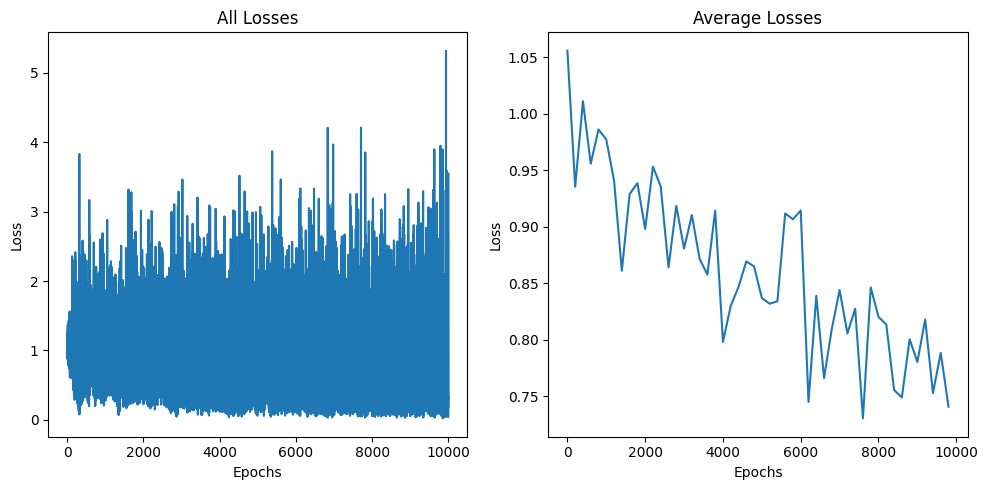

NameError: name 'plot_all_losses2' is not defined

In [31]:
plot_graphs(num_epochs, plot_interval, plot_all_losses1, plot_avg_losses1)
plot_graphs(num_epochs, plot_interval, plot_all_losses2, plot_avg_losses2)
plot_graphs(num_epochs, plot_interval, plot_all_losses3, plot_avg_losses3)

# 3. Testing and Evaluation

In [38]:
# Function to get model's prediction on test data
def predict(model, sentence, aspect, integration_type):
    with torch.no_grad():
        sent = preprocess_data([sentence])[0]
        sent_idx = [word_to_idx[word] for word in sent]
        aspect_idx = word_to_idx[aspect]
        combined_idx = combine_sentence_aspect(sent_idx, aspect_idx)
        aspect_tensor = torch.LongTensor([[aspect_idx]])
        
        if integration_type == 'no aspect':
            input_tensor = torch.LongTensor([[idx] for idx in sent_idx])
            encoder_hiddens = torch.zeros(MAX_LENGTH, model.hidden_size)
        elif integration_type == 'sentence + aspect':
            input_tensor = torch.LongTensor([[idx] for idx in combined_idx])
            encoder_hiddens = torch.zeros(MAX_COMBINED_LENGTH, model.hidden_size)
        elif integration_type == 'word + aspect embedding':
            input_tensor = torch.LongTensor([[idx] for idx in sent_idx])
            encoder_hiddens = torch.zeros(MAX_LENGTH, model.hidden_size)

        input_length = input_tensor.size(0)
        encoder_hidden = model.init_hidden()
        encoder_cell = model.init_hidden()
        for ei in range(input_length):
            is_last = (ei==input_length-1)
            if is_last:
                y_output, (_, _) = model(input_tensor[ei], encoder_hidden, encoder_cell, encoder_hiddens, aspect_tensor, is_last=is_last)
            else:
                _, (encoder_hidden, encoder_cell) = model(input_tensor[ei], encoder_hidden, encoder_cell, encoder_hiddens, aspect_tensor, is_last=is_last)
                encoder_hiddens[ei] = encoder_hidden[0, 0]
            
        _, topi = y_output.topk(1)
        polarity = idx_to_polarity[topi[0].item()]
        return polarity

# Function to calculate model accuracy on test data
def evaluate(model, test_data, integration_type):
    correct = 0
    for i in range(len(test_data)):
        sentence = test_data[i]
        aspect = test_a[i]
        polarity = test_y[i]
        pred_polarity = predict(model, sentence, aspect, integration_type)
        if pred_polarity == polarity:
            correct += 1
    accuracy = correct / len(test_data)
    return accuracy

## Model Evaluation 1

In [39]:
# Get the accuracy of the model on test data
integration_type = 'word + aspect embedding'
accuracy1 = evaluate(model, test_x, integration_type)
print(f"Accuracy: {accuracy1:.4f}")

Accuracy: 0.6138


## Model Evaluation 2

In [18]:
# Get the accuracy of the model on test data
integration_type = 'sentence + aspect'
accuracy2 = evaluate(encoder2, decoder2, test_x, integration_type)
print(f"Accuracy: {accuracy2:.4f}")

Accuracy: 0.5971


## Model Evaluation 3

In [19]:
# Get the accuracy of the model on test data
integration_type = 'no aspect'
accuracy3 = evaluate(encoder3, decoder3, test_x, integration_type)
print(f"Accuracy: {accuracy3:.4f}")

Accuracy: 0.4384
